##二手车交易价格预测
https://tianchi.aliyun.com/competition/entrance/231784/rankingList

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train_data = pd.read_csv('./used_car_train.csv', sep=' ')
test_data = pd.read_csv('./used_car_testB.csv', sep=' ')
#print(train_data.info())
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


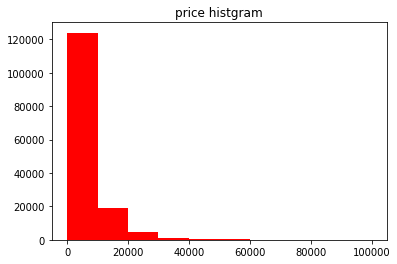

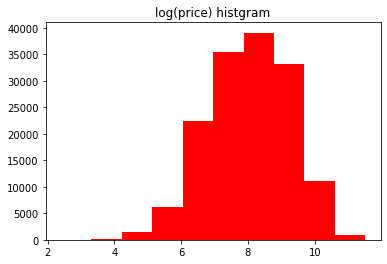

In [53]:
plt.figure(1)
plt.title('price histgram')
plt.hist(train_data['price'], color='red')
plt.figure(2)
plt.title('log(price) histgram')
plt.hist(np.log(train_data['price']), color='red')
plt.show()

In [54]:
train_data['regDate'] = train_data['regDate'].apply(lambda x: np.floor(x/10000))
train_data['creatDate'] = train_data['creatDate'].apply(lambda x: np.floor(x/100))

In [55]:
# 去除非数值类型的值
#print(train_data['notRepairedDamage'].value_counts())
train_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
#print(test_data['notRepairedDamage'].value_counts())
test_data['notRepairedDamage'].replace('-', '0.0', inplace=True)

train_data = train_data.astype('float')
test_data = test_data.astype('float')

# 提取数值类型的列名
numerical_cols = train_data.select_dtypes(exclude='object').columns
#print(numerical_cols)
# 非数值类型
categorical_cols = train_data.select_dtypes(include='object').columns
#print(categorical_cols)

# 特征选择
feature_cols = [col for col in numerical_cols if col not in ['SaleID','price']]
print(feature_cols)

# extract train_data
X_train = train_data[feature_cols]       ###
y_data = train_data['price']          ###
X_test = test_data[feature_cols]
print('train data shape:', X_train.shape)
print('test data shape:', X_test.shape)

# 缺失值补全
X_data = X_train.fillna(-1)
X_test = X_test.fillna(-1)

['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
train data shape: (150000, 29)
test data shape: (50000, 29)


In [56]:
# 统计函数
def show_stats(data):
  print('min = ', np.min(data))
  print('max = ', np.max(data))
  print('max-min = ', np.max(data)-np.min(data))
  print('mean = ', np.mean(data))
  print('var = ', np.var(data))
  print('std = ', np.std(data))
  
show_stats(y_data)

min =  11.0
max =  99999.0
max-min =  99988.0
mean =  5923.327333333334
var =  56279605.94272992
std =  7501.973469876438


In [57]:
# 建立模型
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error   # 平方绝对误差
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [58]:
# 使用xgboost
def build_model_xgb(X_train, y_train):
  model = xgb.XGBRegressor(n_estimator=150, learning_rate=0.1, gamma=0, max_depth=7)
  # training
  model.fit(X_train, y_train)
  return model

def build_model_gbdt(X_train, y_train):
  model = GradientBoostingRegressor(max_depth=7, random_state=10)
  model.fit(X_train, y_train)
  return model

def build_model_lgb(X_train, y_train):
  model = lgb.LGBMRegressor(n_estimators=150, num_leaves=127, learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1)
  model.fit(X_train, y_train)
  return model

In [59]:
xgb_model = build_model_xgb(X_train, y_train)
xgb_pred = xgb_model.predict(X_valid)
mean_absolute_error(y_valid, xgb_pred)

[02:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


638.2225448547522

In [60]:
lgb_model = build_model_lgb(X_train, y_train)
lgb_pred = lgb_model.predict(X_valid)
mean_absolute_error(y_valid, lgb_pred)

586.3321150936453

In [61]:
gbdt_model = build_model_gbdt(X_train, y_train)
gbdt_pred = gbdt_model.predict(X_valid)
mean_absolute_error(y_valid, gbdt_pred)

632.4357101095688

In [62]:
for i in range(len(xgb_pred)):
  if xgb_pred[i] < 0:
    xgb_pred[i] = 100
  if lgb_pred[i] < 0:
    lgb_pred[i] = 100
  if gbdt_pred[i] < 0:
    gbdt_pred[i] = 100
mean_absolute_error(y_valid, xgb_pred)
mean_absolute_error(y_valid, lgb_pred)
mean_absolute_error(y_valid, gbdt_pred)

632.2186213762991

In [63]:
# 模型融合
sum = 586 + 638
#y_pred = (586/sum)*abs(xgb_pred) + (632/sum)*abs(gbdt_pred) + (638/sum)*abs(lgb_pred)
y_pred = (586/sum)*abs(xgb_pred) + (638/sum)*abs(lgb_pred)
#show_stats(y_pred)
# 平均绝对误差(MAE)
mean_absolute_error(y_valid, y_pred)

592.0746480268913

In [64]:
'''
answer = pd.DataFrame()
answer['SaleID'] = test_data.SaleID
answer['price'] = y_pred
answer.to_csv('./ans_xgb.csv', index=False)
'''

"\nanswer = pd.DataFrame()\nanswer['SaleID'] = test_data.SaleID\nanswer['price'] = y_pred\nanswer.to_csv('./ans_xgb.csv', index=False)\n"